In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import skimage
from skimage import filters
from ColorEdgeAwarePerturbs import *

Load the pretrained Inception V3 network

In [2]:
model = models.inception_v3(pretrained=True, init_weights=False)
model.eval();

Establish the preprocess routine.

NOTE: WE DO NOT TRANSFORM THE INPUT IMAGES WITH THE MEAN AND STD OF THE IMAGENET DATASET
WE DO THIS LATER IN THE OUR FUNCTION CALL 'grad_lab2lab'.  
Since we use Inception V3 it is coded in as the default; if one wants to use another neural network, they can add the needed transform below and set the do_imagenet_scale variable as false in this function. 

In [3]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(), 
])

Load images.  In this case we use some military related images pulled from the ImageNet validation set.  Pull the images in and make them a torch object.  Only have four example images in this example.

In [4]:
example_images_set = torchvision.datasets.ImageFolder(root ='./example_images', transform = preprocess)

example_images, labels = [], []
for i in range(4):
    x,y = example_images_set[i]
    example_images.append(x)
    #labels.append(y)
    
example_images = torch.stack(example_images)

Import a dictionary that has all the ImageNet class labels

In [5]:
labelDict = eval(open("./imagenetLabelDict.txt").read())

Import a CSV that has the truth labels for each of our example images

In [6]:
example_image_truth_labels = pd.read_csv('./example_image_labels.csv', sep = ",", header = 0, 
                                         usecols = [2],  nrows = 100)

example_image_truth_labels = example_image_truth_labels.values.squeeze()

Show one of our example images

In [7]:
test_img = example_images[3]
test_label = example_image_truth_labels[3]

[]

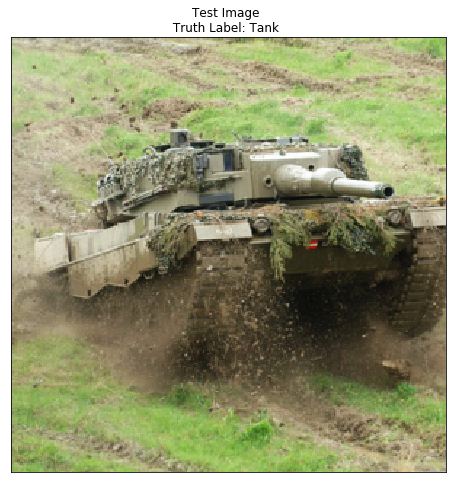

In [8]:
fig, axs = plt.subplots(1,1, figsize = (10,8))

axs.imshow(np.moveaxis(test_img.squeeze(0).numpy(), 0, -1))
axs.title.set_text('Test Image \n Truth Label: %s  ' % (labelDict[test_label].split(",")[0].capitalize()))
axs.set_xticks([])
axs.set_yticks([])


Now let's see how the pretrained neural network classifies this image.  We extract the top 10 highest probabilities and their respective labels.

In [9]:
test_img_probs, test_img_prob_labels = torch.topk(get_probs(model, test_img.unsqueeze(0)),10)


In [10]:
for i in range(len(test_img_probs[0])):
    print('Probability %.4f \tLabel: %s ' % 
          (test_img_probs[0][i], labelDict[test_img_prob_labels[0][i].item()].split(",")[0].capitalize()))

Probability 0.9492 	Label: Tank 
Probability 0.0040 	Label: Amphibian 
Probability 0.0020 	Label: Half track 
Probability 0.0010 	Label: Cannon 
Probability 0.0006 	Label: Bulletproof vest 
Probability 0.0005 	Label: Military uniform 
Probability 0.0005 	Label: Cliff dwelling 
Probability 0.0004 	Label: Projectile 
Probability 0.0004 	Label: Missile 
Probability 0.0003 	Label: Aircraft carrier 


The ImageNet, with ~95% confidence, beleives there is a tank in the image, which we know is correct.

Below is an example of an untargeted attack using Color Aware perturbation on the image above. 

In [11]:
CA_iterations = 5
CA_eps = .1
current_target = test_label

CA_perturbed_img = pert_rgb(test_img, current_target, 
                       model, num_iter = CA_iterations, eps=CA_eps, targeted = False)
CA_probs, CA_prob_labels = torch.topk(get_probs(model, CA_perturbed_img),10)

Probability 0.1209 	Label: Jigsaw puzzle 
Probability 0.0923 	Label: Recreational vehicle 
Probability 0.0280 	Label: Half track 
Probability 0.0170 	Label: Jeep 
Probability 0.0160 	Label: Mobile home 
Probability 0.0139 	Label: Cliff dwelling 
Probability 0.0136 	Label: Catamaran 
Probability 0.0065 	Label: Ambulance 
Probability 0.0065 	Label: Sock 
Probability 0.0060 	Label: Apiary 


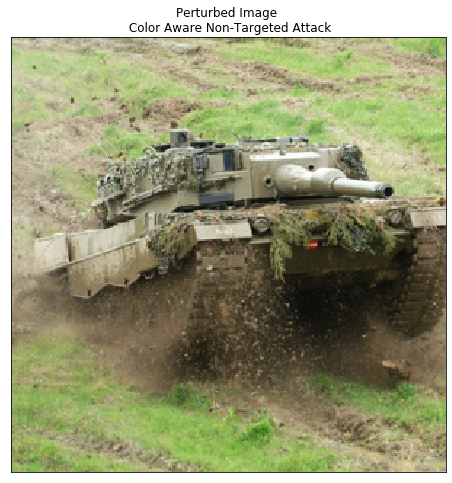

In [12]:
fig, axs = plt.subplots(1,1, figsize = (10,8))

axs.imshow(np.moveaxis(CA_perturbed_img.squeeze(0).numpy(), 0, -1))
axs.title.set_text('Perturbed Image \n Color Aware Non-Targeted Attack')
axs.set_xticks([])
axs.set_yticks([])

for i in range(len(test_img_probs[0])):
    print('Probability %.4f \tLabel: %s ' % 
          (CA_probs[0][i], labelDict[CA_prob_labels[0][i].item()].split(",")[0].capitalize()))

As seen above, the perturbation causes catastrophic failure; however, while the perturbation is not visible to the human eye, it should be obvious that it the image does not contain a jigsaw puzzle.  So now let's do a targeted attack to make the neural network beleive that this tank is actually a less dangerous military vehicle.  Below are the results when we conduct a targeted attack and try to have the network decide that there is an amphibious assault vehicle.

In [13]:
CA_iterations = 5
CA_eps = .1
current_target = 408 # Amphibious vehicle label number in ImageNet

CA_perturbed_img_tgt = pert_rgb(test_img, current_target, 
                       model, num_iter = CA_iterations, eps=CA_eps, targeted = True)
CA_probs_tgt, CA_prob_labels_tgt = torch.topk(get_probs(model, CA_perturbed_img_tgt),10)

Probability 0.9895 	Label: Amphibian 
Probability 0.0059 	Label: Tank 
Probability 0.0009 	Label: Half track 
Probability 0.0003 	Label: Jeep 
Probability 0.0002 	Label: Bulletproof vest 
Probability 0.0002 	Label: Military uniform 
Probability 0.0000 	Label: Assault rifle 
Probability 0.0000 	Label: Terrapin 
Probability 0.0000 	Label: Rifle 
Probability 0.0000 	Label: Projectile 


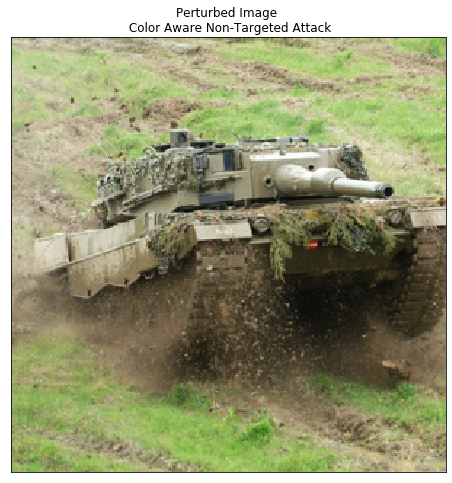

In [14]:
fig, axs = plt.subplots(1,1, figsize = (10,8))

axs.imshow(np.moveaxis(CA_perturbed_img.squeeze(0).numpy(), 0, -1))
axs.title.set_text('Perturbed Image \n Color Aware Targeted Attack')
axs.set_xticks([])
axs.set_yticks([])

for i in range(len(test_img_probs[0])):
    print('Probability %.4f \tLabel: %s ' % 
          (CA_probs_tgt[0][i], labelDict[CA_prob_labels_tgt[0][i].item()].split(",")[0].capitalize()))

Below is the example of using Color & Edge Aware

In [15]:
unpert_gray = test_img.numpy().mean(axis = 0)
weight = torch.tensor(skimage.filters.sobel(unpert_gray))

Below is an example of the weight that is used in Color & Edge Aware

[]

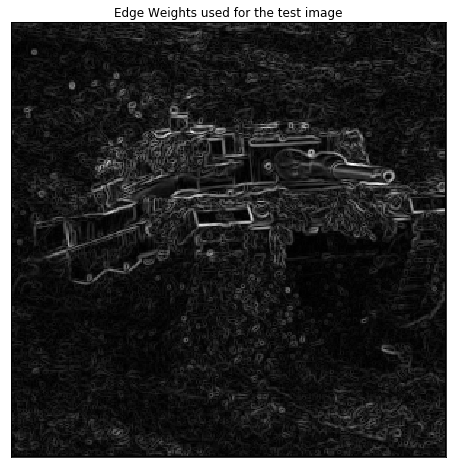

In [21]:
fig, axs = plt.subplots(1,1, figsize = (10,8))

axs.imshow(weight.squeeze(0).numpy(), cmap = 'gray')
axs.title.set_text('Edge Weights used for the test image')
axs.set_xticks([])
axs.set_yticks([])

Non-Targeted Attack Color & Edge Aware

In [17]:
CAE_iterations = 10
CAE_eps = 1.5
current_target = test_label

CAE_perturbed_img = pert_rgb(test_img, current_target, 
                       model, num_iter=CAE_iterations, eps=CAE_eps, targeted = False, weight = weight)
CAE_probs, CAE_prob_labels  = torch.topk(get_probs(model, CAE_perturbed_img),10)

Probability 0.9841 	Label: Recreational vehicle 
Probability 0.0078 	Label: Mobile home 
Probability 0.0007 	Label: Jeep 
Probability 0.0003 	Label: Ambulance 
Probability 0.0002 	Label: Catamaran 
Probability 0.0001 	Label: Fire engine 
Probability 0.0001 	Label: Jigsaw puzzle 
Probability 0.0001 	Label: Alp 
Probability 0.0001 	Label: Beach wagon 
Probability 0.0001 	Label: Cliff dwelling 


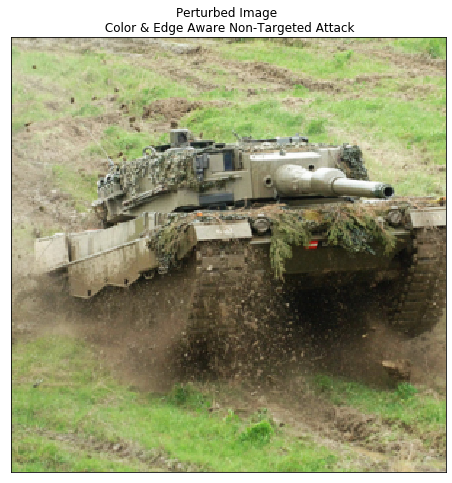

In [22]:
fig, axs = plt.subplots(1,1, figsize = (10,8))

axs.imshow(np.moveaxis(CA_perturbed_img.squeeze(0).numpy(), 0, -1))
axs.title.set_text('Perturbed Image \n Color & Edge Aware Non-Targeted Attack')
axs.set_xticks([])
axs.set_yticks([])

for i in range(len(test_img_probs[0])):
    print('Probability %.4f \tLabel: %s ' % 
          (CAE_probs[0][i], labelDict[CAE_prob_labels[0][i].item()].split(",")[0].capitalize()))

Targeted Color & Edge Aware Attack

In [19]:
CAE_iterations = 10
CAE_eps = 1.5
current_target = 408

CAE_perturbed_img_tgt = pert_rgb(test_img, current_target, 
                       model, num_iter = CAE_iterations, eps = CAE_eps, targeted = True, weight = weight)
CAE_probs_tgt, CAE_prob_labels_tgt  = torch.topk(get_probs(model, CAE_perturbed_img_tgt),10)

Probability 0.9998 	Label: Amphibian 
Probability 0.0001 	Label: Jeep 
Probability 0.0000 	Label: Tank 
Probability 0.0000 	Label: Half track 
Probability 0.0000 	Label: Lakeside 
Probability 0.0000 	Label: Wreck 
Probability 0.0000 	Label: Boathouse 
Probability 0.0000 	Label: Terrapin 
Probability 0.0000 	Label: Dam 
Probability 0.0000 	Label: Bulletproof vest 


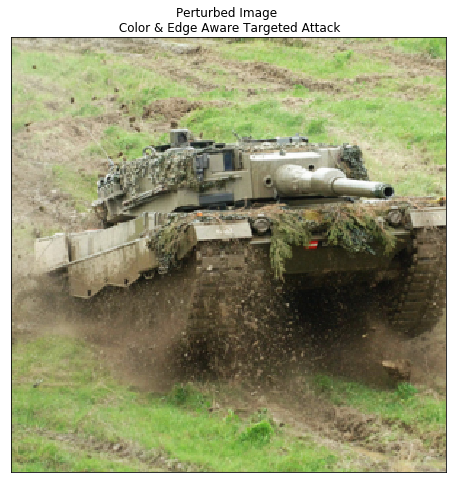

In [23]:
fig, axs = plt.subplots(1,1, figsize = (10,8))

axs.imshow(np.moveaxis(CA_perturbed_img_tgt.squeeze(0).numpy(), 0, -1))
axs.title.set_text('Perturbed Image \n Color & Edge Aware Targeted Attack')
axs.set_xticks([])
axs.set_yticks([])

for i in range(len(test_img_probs[0])):
    print('Probability %.4f \tLabel: %s ' % 
          (CAE_probs_tgt[0][i], labelDict[CAE_prob_labels_tgt[0][i].item()].split(",")[0].capitalize()))